# An example for GPinv.linear_model

This notebook briefly shows an example for GPinv.linear_model.

*Keisuke Fujii 1st Sept. 2016*

## Synthetic observation

Consider we observe a cylindrical transparent mediam with multiple ($N$) lines-of-sight, as shown below.

<img src=cylindrical.png>

The local emission intensity $f$ is a function of the radius $r$.
The observed emission intensity $\mathbf{T}$ is a result of the integration along the line-of-sight as
$$
\mathbf{Y} = \int_{x} f(r) dx + \mathbf{e}
$$

where $\mathbf{e}$ is a i.i.d. Gaussian noise.

We divided $f$ into $n$ discrete points $\mathbf{f}$, then the above integration can be approximated as follows
$$
\mathbf{Y} = \mathrm{A} \mathbf{f} + \mathbf{e}
$$

For the matrix $\mathrm{A}$ construction, 
please see `testing/test_linear_model.py`

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.append('../testing/')
from test_linear_model import make_LosMatrix

## Latent functions

In [2]:
n = 30
N = 40
# radial coordinate
r = np.linspace(0, 1., n)
# synthetic latent function
f = np.exp(-(r-0.3)*(r-0.3)/0.1) + np.exp(-(r+0.3)*(r+0.3)/0.1)

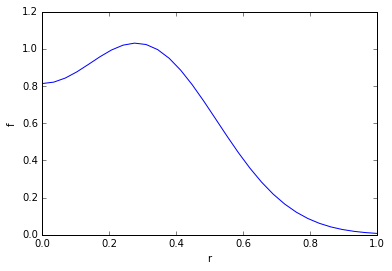

In [3]:
# plotting the latent function
plt.plot(r, f)
plt.xlabel('r')
plt.ylabel('f')

## Synthetic experiment

In [4]:
# los height
z = np.linspace(-0.9,0.9, N)
# Los-matrix
A = make_LosMatrix(r, z)

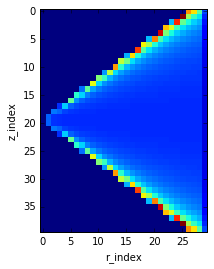

In [5]:
plt.imshow(A, interpolation='nearest')
plt.xlabel('r_index')
plt.ylabel('z_index')

In [6]:
# noise amplitude 
e_amp = 0.1
# synthetic observation
y = np.dot(A, f) + e_amp * np.random.randn(N)

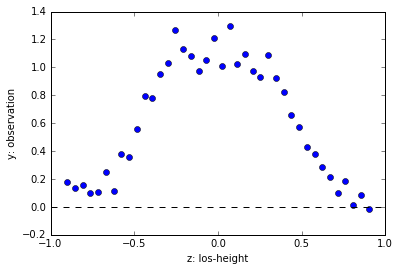

In [7]:
plt.plot(z, y, 'o', [-1,1],[0,0], '--k')
plt.xlabel('z: los-height')
plt.ylabel('y: observation')

## Gaussian Process prior

### Bayesian statistics for the inverse problem
Because the inference of $\mathbf{f}$ from the noisy discrete observation $\mathbf{Y}$ is an inverse problem,
some prior information is necessary.

In the Bayesian context, the posterior distribution can be written by

$$
\mathcal{P}(\mathbf{f}|\mathbf{Y}) 
= \int \mathcal{P}(\mathbf{f}|\mathbf{Y},\theta) 
  \mathcal{P}(\theta)\mathrm{d}\theta
= \int \frac{\mathcal{P}(\mathbf{Y}|\mathbf{f},\theta)\mathcal{P}(\mathbf{f}|\theta)}
            {\mathcal{P}(\mathbf{Y}|\theta)} 
  \mathcal{P}(\theta)\mathrm{d} \theta
$$
where $\theta$ is a set of hyperparameters.

### Gaussian Process

We adopt Gaussian Process (GP) prior for the latent function $f$.

It means any set of realizations of $\mathbf{f}$ follows a multivariate Gaussian,
$$
\mathcal{P}(\mathbf{f}|\theta) = \mathcal{N}(\mathbf{f}|\mathbf{m}_f(\theta), \mathrm{K}(\theta))
$$

### MAP estimates of the hyperparameter $\theta$.

For the evaluation of $\theta$, we adopt the maximum posterior estimates of $\theta$, 
where posterior of $\theta$ is
$$
\theta^\mathrm{MAP} = 
\mathrm{argmax}_\theta \left(\mathcal{P}(\theta|\mathbf{Y}) \right)
=
\mathrm{argmax}_\theta \left( \mathcal{P}(\mathbf{Y}|\theta) \mathcal{P}(\theta)\right)
$$


# Typical Usage

In [8]:
import GPinv
import GPflow

In [9]:
model = GPinv.linear_model.LinearModel(
        r.reshape(-1,1), y.reshape(-1,1), Amat=A, kern = GPflow.kernels.RBF(1))

In [10]:
model.optimize()

compiling tensorflow function...
done
optimization terminated, setting model state


      fun: -31.289640833495724
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.11294843e-06,   9.39391730e-07,  -2.35067390e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 23
      nit: 18
   status: 0
  success: True
        x: array([-4.90394864, -1.08868739, -1.00840573])

## Predict the latent function

In [11]:
r_new = np.linspace(0.,1., 19)
f_mu, f_var = model.predict_f(r_new.reshape(-1,1))

In [12]:
f_mu = f_mu.flatten()
f_var = f_var.flatten()

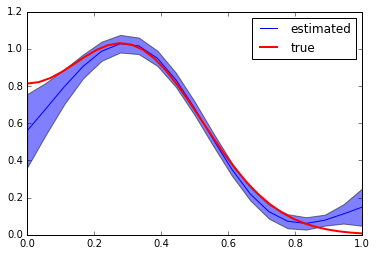

In [13]:
plt.fill_between(r_new, f_mu+np.sqrt(f_var), f_mu-np.sqrt(f_var), alpha=0.5)
plt.plot(r_new, f_mu, label='estimated')
plt.plot(r, f, '-r', label='true',lw=2)
plt.plot([0,1],[0,0],'--k')
plt.legend(loc='best')

## Predict the data

In [14]:
y_mu, y_var = model.predict_y()

In [15]:
y_mu = y_mu.flatten()
y_var = y_var.flatten()

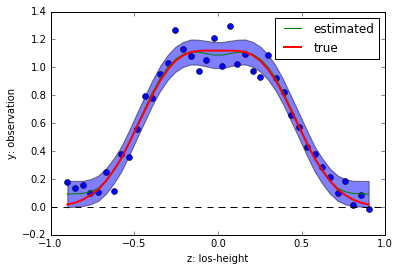

In [16]:
plt.plot(z, y, 'o', [-1,1],[0,0], '--k')
plt.fill_between(z, y_mu+np.sqrt(y_var), y_mu-np.sqrt(y_var), alpha=0.5)
plt.plot(z, y_mu, label='estimated')
plt.plot(z, np.dot(A, f), 'r', label='true',lw=2)
plt.plot([0,1],[0,0],'--k')
plt.legend(loc='best')
plt.xlabel('z: los-height')
    plt.ylabel('y: observation')